# LSTM On Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Vanilla LSTM<br>
6. Stacked LSTM<br>
7. CNN-LSTM<br>
8. Bidirectional LSTM<br>
9. Conclusion<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For a given Amazon review, classify it as "Possitive"(Rating of 4 or 5) or "Negative"(Rating of 1 or 2).<br>
<br>
Here I'm using LSTM algorithm to classify reviews as 'positive' or 'negative'. To convert a review text to numerical features I'm using bag of words, TF-IDF, avg Word2Vec, TF-IDF weighted Word2Vec. 

In [2]:
import numpy as np 
import sqlite3
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 3. Loading the data

In [5]:
# Loading the previously cleaned data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

In [6]:
data.shape

(364171, 12)

In [7]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## 4. Data Preprocessing 

In [8]:
data.Score.value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [9]:
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
# converting 'positive' score to 1 and 'negative' score to 0
def partition(x):
    if x == 'positive':
        return 1
    return 0

actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

In [11]:
sorted_data.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [12]:
score = np.array(sorted_data.Score.reshape(sorted_data.shape[0],1))

In [13]:
def data_split(data, score):
    train_x, test_x, train_y, test_y = train_test_split(data, score, test_size = 0.3, shuffle = False)
    return train_x, test_x, train_y, test_y

In [14]:
train_x, test_x, train_y, test_y = data_split(sorted_data, score)

In [15]:
import nltk 
from nltk.corpus import stopwords

In [16]:
import operator

def find_top_words(num_top):
    all_words = []
    stop_words = set(stopwords.words('english', ignore_lines_startswith = 'not'))
    for sent in sorted_data['CleanedText'].values:
        for word in sent.decode('utf-8').split():
            if word not in stop_words:
                all_words.append(word)
    words_dist = nltk.FreqDist(all_words)
    words_sorted = sorted(words_dist.items(), key = operator.itemgetter(1))[::-1][: num_top]
    words_sorted = dict((x, y) for x, y in words_sorted)
    
    for i, w in enumerate(words_sorted):
        words_sorted[w] = i + 1
    
    return words_sorted

In [17]:
num_top_words = 10000

In [18]:
ranked_dict = find_top_words(num_top_words)

In [19]:
def rank_vect(data):
    complete_text_rank = []
    for sent in data:
        sent_rank = []
        for word in sent.decode('utf-8').split():
            if word in ranked_dict:
                sent_rank.append(ranked_dict[word])
            else:
                sent_rank.append(0)
        complete_text_rank.append(sent_rank)
    return complete_text_rank      

In [20]:
train_rank = rank_vect(train_x['CleanedText'].values)

In [21]:
test_rank = rank_vect(test_x['CleanedText'].values)

In [22]:
train_rank[1]

[536,
 136,
 656,
 1003,
 6216,
 45,
 307,
 970,
 1179,
 563,
 63,
 42,
 3604,
 109,
 7,
 3449,
 1076,
 5066,
 2041,
 3597,
 4703,
 325,
 133,
 996,
 56,
 540,
 1076,
 821,
 750,
 287]

In [23]:
vec_length = 500
train_vect = sequence.pad_sequences(train_rank, maxlen = vec_length)
test_vect = sequence.pad_sequences(test_rank, maxlen = vec_length)

In [24]:
train_vect[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [25]:
train_vect.shape

(254919, 500)

In [26]:
test_vect.shape

(109252, 500)

## 5. Vanilla LSTM

In [27]:
def err_plot(history):
    
    sns.set()
    # train-cv plot for accuracy
    plt.figure(figsize = (8, 5))
    plt.plot(np.arange(1, 11, step = 1), history.history['acc'], color = 'blue')
    plt.plot(np.arange(1, 11, step = 1), history.history['val_acc'], color = 'red')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'CV'])
    plt.show()
        
    # train-cv plot for loss
    plt.figure(figsize = (8, 5))
    plt.plot(np.arange(1, 11, step = 1), history.history['loss'], color = 'blue')
    plt.plot(np.arange(1, 11, step = 1), history.history['val_loss'], color = 'red')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'CV'])
    plt.show()

In [28]:
from keras.layers import CuDNNLSTM

In [243]:
embedding_vec_length = 64
model = Sequential()
model.add(Embedding(num_top_words, embedding_vec_length, input_length = vec_length))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 500, 64)           640000    
_________________________________________________________________
dropout_48 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
cu_dnnlstm_82 (CuDNNLSTM)    (None, 128)               99328     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 739,457
Trainable params: 739,457
Non-trainable params: 0
_________________________________________________________________
None


****************************TRAINING****************************
Train on 203935 samples, validate on 50984 samples
Epoch 1/10
203935/203935 [==============================] - 70s 341us/step - loss: 0.2042 - acc: 0.9198 - val_loss: 0.1854 - val_acc: 0.9274
Epoch 2/10
203935/203935 [==============================] - 68s 333us/step - loss: 0.1549 - acc: 0.9401 - val_loss: 0.1814 - val_acc: 0.9257
Epoch 3/10
203935/203935 [==============================] - 68s 335us/step - loss: 0.1319 - acc: 0.9495 - val_loss: 0.1626 - val_acc: 0.9363
Epoch 4/10
203935/203935 [==============================] - 68s 336us/step - loss: 0.1154 - acc: 0.9558 - val_loss: 0.1672 - val_acc: 0.9357
Epoch 5/10
203935/203935 [==============================] - 69s 338us/step - loss: 0.1020 - acc: 0.9616 - val_loss: 0.1759 - val_acc: 0.9347
Epoch 6/10
203935/203935 [==============================] - 69s 338us/step - loss: 0.0899 - acc: 0.9663 - val_loss: 0.1767 - val_acc: 0.9359
Epoch 7/10
203935/203935 [============

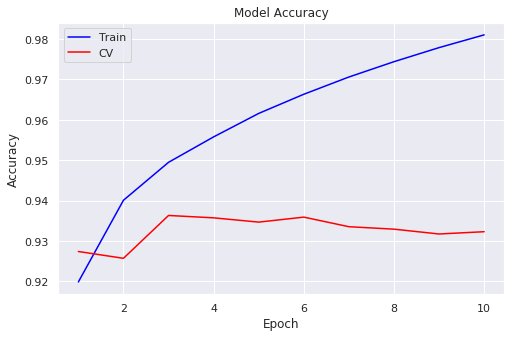

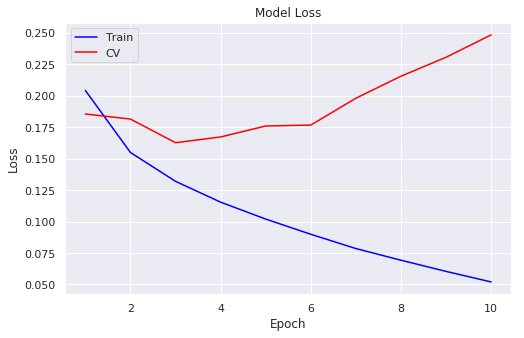

In [244]:
print('****************************TRAINING****************************')
history = model.fit(train_vect, train_y, epochs = 10, batch_size = 64, validation_split = 0.2)
err_plot(history)

In [245]:
print('****************************TESTING****************************')
model.fit(train_vect, train_y, epochs = 3, batch_size = 64)
result = model.evaluate(test_vect, test_y)
print("Accuracy: %.2f%%" % (result[1] * 100))

****************************TESTING****************************
Epoch 1/3
254919/254919 [==============================] - 79s 311us/step - loss: 0.0840 - acc: 0.9717
Epoch 2/3
254919/254919 [==============================] - 85s 332us/step - loss: 0.0683 - acc: 0.9760
Epoch 3/3
109252/109252 [==============================] - 22s 205us/step
Accuracy: 93.10%


## 6. Stacked LSTM

In [48]:
embedding_vec_length = 64
model = Sequential()
model.add(Embedding(num_top_words, embedding_vec_length, input_length = vec_length))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(128, return_sequences = True))
model.add(Dropout(0.3))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 64)           640000    
_________________________________________________________________
dropout_14 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 500, 128)          99328     
_________________________________________________________________
dropout_15 (Dropout)         (None, 500, 128)          0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 128)               132096    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 871,553
Trainable params: 871,553
Non-trainable params: 0
_________________________________________________________________
None

****************************TRAINING****************************
Train on 203935 samples, validate on 50984 samples
Epoch 1/10
203935/203935 [==============================] - 151s 740us/step - loss: 0.2030 - acc: 0.9206 - val_loss: 0.1861 - val_acc: 0.9282
Epoch 2/10
203935/203935 [==============================] - 139s 683us/step - loss: 0.1514 - acc: 0.9420 - val_loss: 0.1620 - val_acc: 0.9356
Epoch 3/10
203935/203935 [==============================] - 140s 686us/step - loss: 0.1294 - acc: 0.9508 - val_loss: 0.1637 - val_acc: 0.9369
Epoch 4/10
203935/203935 [==============================] - 140s 688us/step - loss: 0.1145 - acc: 0.9567 - val_loss: 0.1612 - val_acc: 0.9364
Epoch 5/10
203935/203935 [==============================] - 141s 689us/step - loss: 0.1014 - acc: 0.9624 - val_loss: 0.1749 - val_acc: 0.9367
Epoch 6/10
203935/203935 [==============================] - 141s 693us/step - loss: 0.0898 - acc: 0.9665 - val_loss: 0.1782 - val_acc: 0.9355
Epoch 7/10
203935/203935 [======

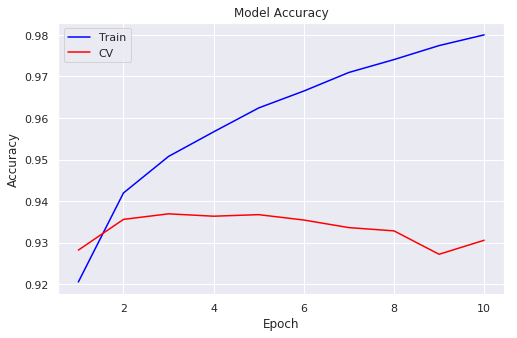

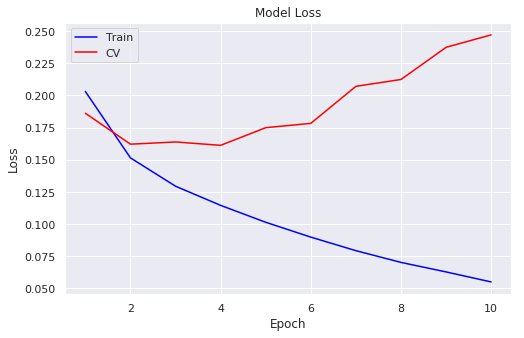

In [31]:
print('****************************TRAINING****************************')
history = model.fit(train_vect, train_y, epochs = 10, batch_size = 64, validation_split = 0.2)
err_plot(history)

In [49]:
print('****************************TESTING****************************')
model.fit(train_vect, train_y, epochs = 2, batch_size = 64)
result = model.evaluate(test_vect, test_y)
print("Accuracy: %.2f%%" % (result[1] * 100))

****************************TESTING****************************
Epoch 1/2
254919/254919 [==============================] - 160s 629us/step - loss: 0.1985 - acc: 0.9222
Epoch 2/2
109252/109252 [==============================] - 44s 401us/step
Accuracy: 93.70%


## 7. CNN-LSTM

In [33]:
from keras.layers import Conv1D, MaxPooling1D

In [46]:
embedding_vec_length = 64
model = Sequential()
model.add(Embedding(num_top_words, embedding_vec_length, input_length = vec_length))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 500, 64)           640000    
_________________________________________________________________
dropout_13 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 496, 64)           20544     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 128)               99328     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 760,001
Trainable params: 760,001
Non-trainable params: 0
_________________________________________________________________
None

****************************TRAINING****************************
Train on 203935 samples, validate on 50984 samples
Epoch 1/10
203935/203935 [==============================] - 36s 175us/step - loss: 0.1958 - acc: 0.9228 - val_loss: 0.1756 - val_acc: 0.9310
Epoch 2/10
203935/203935 [==============================] - 35s 172us/step - loss: 0.1432 - acc: 0.9445 - val_loss: 0.1687 - val_acc: 0.9344
Epoch 3/10
203935/203935 [==============================] - 36s 174us/step - loss: 0.1184 - acc: 0.9549 - val_loss: 0.1789 - val_acc: 0.9299
Epoch 4/10
203935/203935 [==============================] - 36s 175us/step - loss: 0.0969 - acc: 0.9638 - val_loss: 0.1895 - val_acc: 0.9276
Epoch 5/10
203935/203935 [==============================] - 36s 175us/step - loss: 0.0791 - acc: 0.9712 - val_loss: 0.2083 - val_acc: 0.9254
Epoch 6/10
203935/203935 [==============================] - 36s 176us/step - loss: 0.0647 - acc: 0.9768 - val_loss: 0.2313 - val_acc: 0.9167
Epoch 7/10
203935/203935 [============

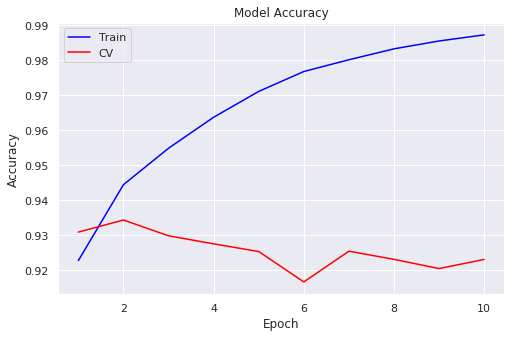

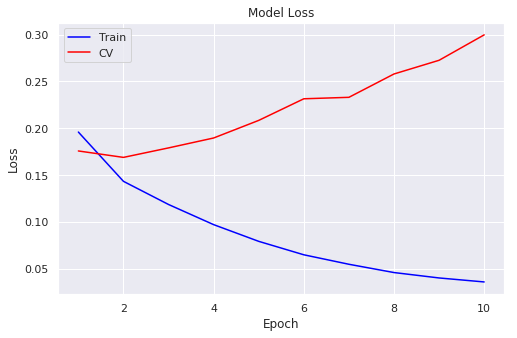

In [36]:
print('****************************TRAINING****************************')
history = model.fit(train_vect, train_y, epochs = 10, batch_size = 64, validation_split = 0.2)
err_plot(history)

In [47]:
print('****************************TESTING****************************')
model.fit(train_vect, train_y, epochs = 2, batch_size = 64)
result = model.evaluate(test_vect, test_y)
print("Accuracy: %.2f%%" % (result[1] * 100))

****************************TESTING****************************
Epoch 1/2
254919/254919 [==============================] - 42s 166us/step - loss: 0.1891 - acc: 0.9253
Epoch 2/2
109252/109252 [==============================] - 9s 78us/step
Accuracy: 93.40%


## 7. Bidirectional LSTM

In [41]:
from keras.layers import Bidirectional

In [43]:
embedding_vec_length = 64
model = Sequential()
model.add(Embedding(num_top_words, embedding_vec_length, input_length = vec_length))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(CuDNNLSTM(64)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 64)           640000    
_________________________________________________________________
dropout_11 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 500, 256)          198656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 500, 256)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,003,649
Trainable params: 1,003,649
Non-trainable params: 0
_________________________________________________________________


****************************TRAINING****************************
Train on 203935 samples, validate on 50984 samples
Epoch 1/10
203935/203935 [==============================] - 272s 1ms/step - loss: 0.2016 - acc: 0.9210 - val_loss: 0.1811 - val_acc: 0.9292
Epoch 2/10
203935/203935 [==============================] - 274s 1ms/step - loss: 0.1483 - acc: 0.9423 - val_loss: 0.1650 - val_acc: 0.9363
Epoch 3/10
203935/203935 [==============================] - 277s 1ms/step - loss: 0.1273 - acc: 0.9513 - val_loss: 0.1638 - val_acc: 0.9375
Epoch 4/10
203935/203935 [==============================] - 276s 1ms/step - loss: 0.1118 - acc: 0.9578 - val_loss: 0.1678 - val_acc: 0.9376
Epoch 5/10
203935/203935 [==============================] - 276s 1ms/step - loss: 0.0989 - acc: 0.9630 - val_loss: 0.1777 - val_acc: 0.9368
Epoch 6/10
203935/203935 [==============================] - 277s 1ms/step - loss: 0.0880 - acc: 0.9672 - val_loss: 0.1835 - val_acc: 0.9363
Epoch 7/10
203935/203935 [==================

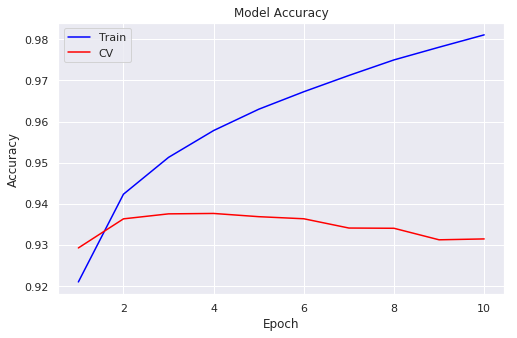

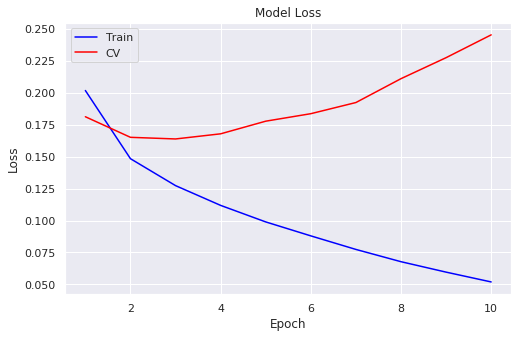

In [44]:
print('****************************TRAINING****************************')
history = model.fit(train_vect, train_y, epochs = 10, batch_size = 64, validation_split = 0.2)
err_plot(history)

In [45]:
print('****************************TESTING****************************')
model.fit(train_vect, train_y, epochs = 2, batch_size = 64)
result = model.evaluate(test_vect, test_y)
print("Accuracy: %.2f%%" % (result[1] * 100))

****************************TESTING****************************
Epoch 1/2
254919/254919 [==============================] - 311s 1ms/step - loss: 0.0823 - acc: 0.9722
Epoch 2/2
109252/109252 [==============================] - 84s 767us/step
Accuracy: 93.33%


## 8. Summary

### Approach:
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;From all Amazon fine food reviews data-points i have taken only the reviews that have score 1, 2, 4 or 5 and applied some text preprocessing. After than I loaded the data to apply various LSTMs to classify our data into positive class or negative class. LSTMs need input sequence in some sort of embeddings. For that I have taken top 10000 words from the total text corpus and calculated the rank matrix and represented train and test text in terms of rank of the words of fixed length of 500; except that embedding vector length is taken to be 64.  Every LSTM's performances is presented below.<br>
<h3> Results:</h3><br>
 <table>
  <tr>
    <th>LSTM Variant Name</th>
    <th>Total Parameters</th>
    <th>Train Accuracy</th>
    <th>Test Accuracy</th>
  </tr>
  <tr>
    <td>Vanilla LSTM</td>
    <td>739456</td>
    <td>97.95%</td>
    <td>93.10%</td>
  </tr>
  <tr>
    <td>Stacked LSTM</td>
    <td>871553</td>
    <td>94.27%</td>
    <td>93.70%</td>
  </tr>
  <tr>
    <td>CNN-LSTM</td>
    <td>760001</td>
    <td>94.58%</td>
    <td>93.40%</td>
    <td></td>
  </tr>
  <tr>
    <td>Bidirectional LSTM</td>
    <td>1003649</td>
    <td>97.63%</td>
    <td>93.33%</td>
  </tr>
</table>
<br>

<h3>Conclusion:</h3><br>

**1.** Textual data comes under sequential data so it's better to apply LSTM to it.<br>
**2.** For 128 LSTM units it seems the model overfits the data very quickly. So, I managed to reduce the overfitting to some extent by using a dropout layer before the LSTM layer in all LSTMs.<br>
**3.** All LSTM variants performed similar to each other. But, among all of them Stacked LSTM with 2 LSTM layers with 128 LSTM units performed best with accuracy of 93.70%.<br>